# Optional Content: Discovering the PDF Layers
## Introduction
Handling PDF files is a common task in the world of software development, whether it is reading, writing, or editing PDF documents. Python, a versatile and powerful programming language, has numerous libraries to aid in this process. One of these libraries is PyMuPDF, a wrapper around the popular MuPDF library.

PyMuPDF offers an intuitive and efficient interface to easily work with PDF files. Both, its range of functions and its performance make it a leader among Python PDF libraries.

In this blog post, we will look at a PDF feature hardly any other package seems to be bothering about: **PDF Optional Content.** We will be covering the following topics:

1. Overview: What are PDF optional content layers?
2. How to create a PDF with layers
3. How to access the content of layers


## Overview: What are PDF optional content layers?
Optional Content is a PDF feature to show or hide objects. An object's visibility can be made dependent on the bool value of a special other object type, a so-called Optional Content Group (OCG).

OCGs may be true or false ("ON" or "OFF"). A PDF object (text, image, vector graphics, etc.) will be invisible (visible) if there is an OCG object attached to it that has the status OFF (ON). Any object can only have one OCG attached to it.

A PDF with optional content will usually contain multiple OCGs. Different configurations of OCG states may be stored in separate so-called **layers**, which can be activated - either temporarily or permanently - and will thus set the state of many OCGs at the same time - and hence the visibility of many PDF objects.

A PDF will always have a standard OC layer (or none if without Optional Content support). The standard layer is the one activated when the PDF is being openend.

More complexity comes into play with **OCMD**s (Optional Content Membership Dictionaries): Those are logical expressions of the state of one or more OCGs within any given layer.

As mentioned, the visibility of any PDF object can only depend on **_one_** item. **_But_** that item may also be an OCMD, the state of which can depend on multiple OCGs. So a condition like **_"show this text if OCG1 is not ON"_** can be put in an OCMD and attached to the text.

The Optional Content capability is useful in complex PDF documents containing items such as CAD drawings, technical construction plans, layered artwork, maps, or multi-language documents.

## How to create a PDF with layers
In this section we will create a **_bilingual_** PDF page from scratch, which shows English and alternatively German text in a rectangle with gray background and a blue border.

The standard page appearance will show the English text and the rectangle. The German text will be shown automatically whenever English is set to OFF.

> We are assuming here that you have basic Knowledge about how to install PyMuPDF and how to open or close documents using this package. To be sure, please consult the documention [here](https://pymupdf.readthedocs.io/en/latest/the-basics.html).

The following code block does some preparations to simplify later work. Specifically we are using a package capable of displaying images inline here.

In [1]:
# making sure we have all required packages installed
#!python -m pip install pymupdf
#!python -m pip install matplotlib

import fitz  # import PyMuPDF

def show_image(item, title):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: a PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and uses matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    %matplotlib inline
    import numpy as np
    import matplotlib.pyplot as plt
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set titel of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

Here comes the actual application code.

> The English text is quoted from [this](https://en.wikipedia.org/wiki/False_killer_whale) Wikipedia page. The German text is quoted from [here](https://de.wikipedia.org/wiki/Kleiner_Schwertwal).

In [2]:
# This is the rectangle we want to draw as text background
rect = fitz.Rect(50, 50, 400, 300)

doc = fitz.open()  # make a new PDF
# also give it a page - a bit larger than above rectangle
page = doc.new_page(height=400, width=500)

# The two text definitions: English and German
text_en = (
    "The false killer whale (Pseudorca crassidens) is a species of oceanic"
    " dolphin that is the only extant representative of the genus Pseudorca."
    " It is found in oceans worldwide but mainly in tropical regions."
    " It was first described in 1846 as a species of porpoise based on a skull,"
    " which was revised when the first carcasses were observed in 1861."
    " The name 'false killer whale' comes from having a skull similar to the"
    " orca (Orcinus orca), or killer whale."
    "\nThe false killer whale reaches a maximum length of 6 m (20 ft), though"
    " size can vary around the world. It is highly sociable, known to form"
    " pods of up to 50 members, and can also form pods with other dolphin"
    " species, such as the common bottlenose dolphin (Tursiops truncatus)."
)
text_de = (
    "Der Kleine Schwertwal (Pseudorca crassidens), auch bekannt als Unechter"
    " oder Schwarzer Schwertwal, ist eine Art der Delfine (Delphinidae) und"
    " der einzige rezente Vertreter der Gattung Pseudorca. Er ähnelt dem"
    " Orca in Form und Proportionen, ist aber einfarbig schwarz und mit"
    " einer Maximallänge von etwa sechs Metern deutlich kleiner. Kleine"
    " Schwertwale bilden Schulen von durchschnittlich zehn bis fünfzig"
    " Tieren, wobei sie sich auch mit anderen Delfinen vergesellschaften und"
    " sich meistens abseits der Küsten aufhalten. Sie sind in allen Ozeanen"
    " gemäßigter, subtropischer und tropischer Breiten beheimatet, sind"
    " jedoch vor allem in wärmeren Jahreszeiten auch bis in die gemäßigte"
    " bis subpolare Zone südlich der Südspitze Südamerikas, vor Nordeuropa"
    " und bis vor Kanada anzutreffen."
)

The following three code lines define the necessary Optional Content specifications:
* `oc_gr` and `oc_en` are **_OCGs_** which automatically will be set to ON. Only the **name** is mandatory in the definition.
* `oc_de` is an **_OCMD_**. We make it dependent on the status of `oc_en` by the `policy` parameter: its status will be ON whenever all of the OCGs in list `ocgs` are OFF. As we only have one OCG to depend on (`oc_en`), the effect is that exactly one of either English or German is displayed.

In [3]:
oc_gr = doc.add_ocg("graphics", on=True)
oc_en = doc.add_ocg("english", on=True)
oc_de = doc.set_ocmd(ocgs=[oc_en], policy="AllOff")  # effect: ON if and only if oc_en is OFF

The remaining code ...
* Draws the gray rectangle giving it the "graphics" OCG.
* Inserts the English text in the rectangle, giving it the "english" OCG.
* Inserts the German text in the same rectangle, giving it the OCMD.

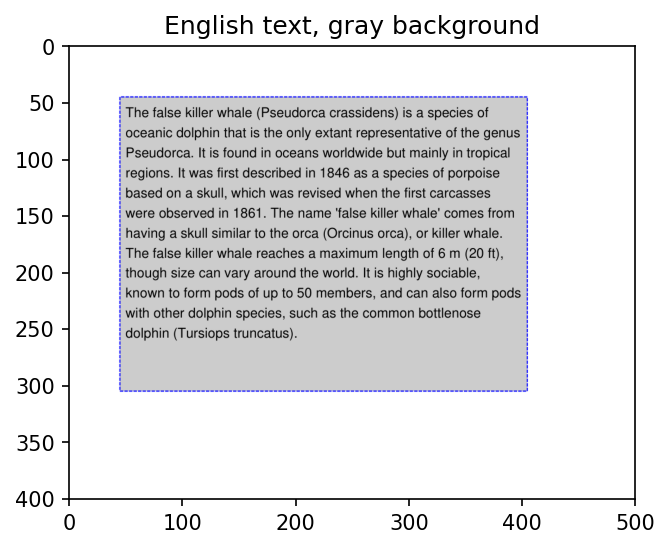

In [4]:
# Draw rectangle first so it is background for the text
page.draw_rect(
    rect + (-5, -5, 5, 5),  # 5 points larger in every direction for nicer text appearance
    fill=fitz.pdfcolor["gray80"],  # fill color some gray
    color=fitz.pdfcolor["blue"],  # border color blue
    oc=oc_gr,  # give it the "graphics" OCG
    dashes="[3 1]",  # dashed border: 3 points followed by 1 point gap
)

# Write the text into the rectangle. Line breaks will occur automatically.
page.insert_textbox(
    rect,  # the "box"
    text_en,  # English text
    fontsize=12,  # font size
    oc=oc_en,  # give it the "english" OCG
)

page.insert_textbox(
    rect,  # the "box"
    text_de,  # German text
    fontsize=12,  # font size
    oc=oc_de,  # give it the non-"english" OCMD
)

# ------------------------------------------------------------------------------------
# Just some technical stuff - required by our notebook environment only:
# Recycle the PDF and show what we have done so far.
# ------------------------------------------------------------------------------------
pdfbytes = doc.tobytes(clean=True)
doc.close()
# reopen just created PDF
doc=fitz.open(stream=pdfbytes)
# load our prepared page
page=doc[0]
# display the page image
show_image(page, "English text, gray background")

The above defined Optional Content objects, `oc_gr`, `oc_en`, `oc_de` are valid for the whole document. They can be attached to other objects on this or on other pages throughout the PDF. For example, on other pages we may have more text we want to show in bilingual mode, or other graphical objects. All of them  will be visible or hidden in sync with their attached OC object.

In the next section we will show how to programmatically explore the Optional Content situation and show or hide objects.

## How to access content of layers
In this section we will show you how to navigate through a PDF's Optional Content information. You will learn how to detect that there in fact **exists** content not reachable in normal view and then switch visibility states to make that content available.

The main two methods are:
1. `doc.layer_ui_configs()`: This is a tuple of dictionaries. If the empty tuple `()` is returned, the PDF has no Optional Content. Each dictionary describes an OCG with the following important keys:
    - 'locked': (bool) whether the state may be changed at all
    - 'number': (int) identifying number
    - 'on': (bool) current state
    - 'text': (str) the name given to the OCG
2. `doc.set_layer_ui_config(number, action)`: Use this to change the state of one of the OCGs, numbered as shown. This method does the same thing as offered by supporting PDF viewers.
    - `action` is an integer with the following meanings: 0 = set on (default), 1 = toggle on/off, 2 = set off.

In [5]:
# display the mofifiable OCGs and their state
for item in doc.layer_ui_configs():
    print(item)

{'number': 0, 'text': 'graphics', 'depth': 0, 'type': 'checkbox', 'on': True, 'locked': False}
{'number': 1, 'text': 'english', 'depth': 0, 'type': 'checkbox', 'on': True, 'locked': False}


First we will switch "english" to OFF and observe the appearance change of the page: the English text has been replaced by German.

Extracting the page's text **now** would likewise deliver text in German!

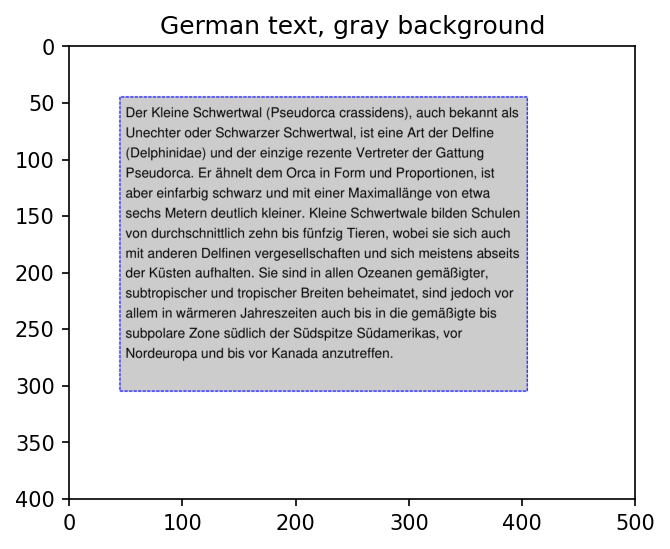

In [6]:
doc.set_layer_ui_config(1, action=2)  # switch OFF "english"
show_image(page, "German text, gray background")  # show page again

Now switch off the rectangle and look again: the gray rectangle will also disappear.

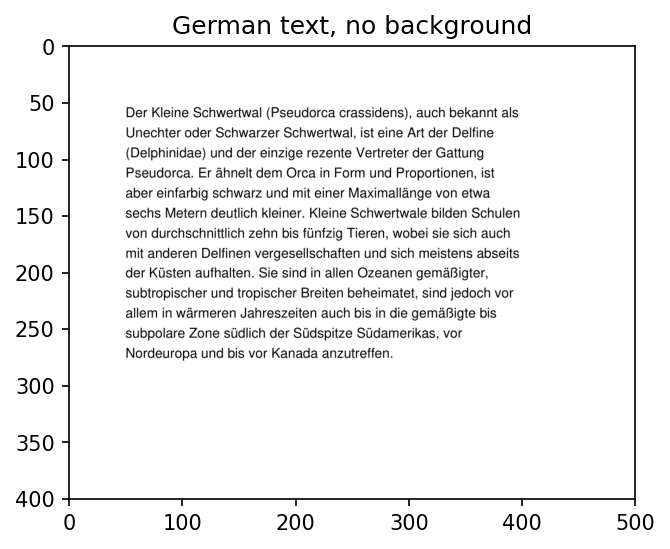

In [7]:
doc.set_layer_ui_config(0, action=2)  # switch OFF "english"
show_image(page, "German text, no background")  # show page again

Similar to using a PDF viewer to switch OCGs on or off, these methods will not permanently modify your PDF either.

But this is possible as well. For example, to permanently change the *default* visibility of English text and the graphics to OFF, execute `doc.set_layer(off=[oc_en, oc_gr])`. This will cause these OCGs to be OFF when the PDF is opened next time.

We recommend to explore the documenation as mentioned in the following section.

## Conclusion
In this blog post we have learned,

1. how to create an English-German bilingual PDF document,
2. how to detect the presence of hidden Optional Content and how to access it,
3. how to permanently change default visibility

using PyMuPDF.

By using these steps you should be able to create your own documents and to programmatically uncover hidden content in PDF documents.

Remember, the PyMuPDF library offers a plethora of other features to work with PDF and other documents, such as extracting text, images, annotations, and much more. Make sure to explore the official PyMuPDF [documentation](https://pymupdf.readthedocs.io/en/latest/) to discover more about its capabilities.